# Energy Consumption Time Series Exercise - Data Exploration and Preprocessing

## Load the data

** Import required libraries: numpy pandas and matplotlib **

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

** Use pandas to read the train and test csv files **

In [2]:
#Please update the path to the train and test files
train = pd.read_csv('usage_train.csv')
test = pd.read_csv('usage_test.csv')

** Check out the head of the dataframe**

In [3]:
train.head()

,id,datetime,usage
0,MAC003828,2012-12-17 09:00:00,0.073
1,MAC003828,2012-12-17 09:30:00,0.054
2,MAC003828,2012-12-17 10:00:00,0.069
3,MAC003828,2012-12-17 10:30:00,0.070
4,MAC003828,2012-12-17 11:00:00,0.049


## Pivoting the data
A quick look at the data reveals it's actually for multiple households (the id column has 10 unique values, each is repeated 17184 times)

This means it makes sense to pivot the data and have each household as a separate column, have the datatime couln as the index and cell values will be the readings (i.e. usage)

In [4]:
print(train.id.unique())
print(train.id.value_counts())

['MAC003828' 'MAC003685' 'MAC005415' 'MAC000085' 'MAC004671' 'MAC004218'
 'MAC001757' 'MAC004166' 'MAC000246' 'MAC000094']
MAC004166    17184
MAC003685    17184
MAC005415    17184
MAC004671    17184
MAC000246    17184
MAC001757    17184
MAC003828    17184
MAC000085    17184
MAC004218    17184
MAC000094    17184
Name: id, dtype: int64


In [5]:
new_train = train.pivot(index='datetime', columns='id', values='usage')
new_test = test.pivot(index='datetime', columns='id')# test has no values for household columns

In [6]:
print(new_train.shape)
print(new_test.shape)
print(new_test.columns)

(17184, 10)
(336, 0)
MultiIndex(levels=[[], ['MAC000085', 'MAC000094', 'MAC000246', 'MAC001757', 'MAC003685', 'MAC003828', 'MAC004166', 'MAC004218', 'MAC004671', 'MAC005415']],
           labels=[[], []],
           names=[None, 'id'])


In [7]:
new_train.head()

id,MAC000085,MAC000094,MAC000246,MAC001757,MAC003685,MAC003828,MAC004166,MAC004218,MAC004671,MAC005415
datetime,,,,,,,,,,
2012-12-17 09:00:00,0.792,0.124,0.057,0.181,0.118,0.073,0.139,0.496,0.220,0.018
2012-12-17 09:30:00,0.284,0.124,0.055,0.195,0.314,0.054,0.103,0.985,0.214,0.119
2012-12-17 10:00:00,0.151,0.123,0.064,0.342,0.105,0.069,0.120,1.050,0.204,0.110
2012-12-17 10:30:00,0.416,0.154,0.049,0.140,0.583,0.070,0.121,1.117,0.250,0.054
2012-12-17 11:00:00,0.114,0.164,0.025,0.129,0.747,0.049,0.087,1.133,0.242,0.079


## Important
Please notice I am going to compute the average (or median) usage of all households and use it to create a model and predict  the future usage of households using this model. I can easily create a sepratae model for each household but the purpose here is to demonstrate that I can deal with Time Series Data. I hope you are ok with this!

** Compute the mean usage **

In [8]:
new_train['mean_usage'] = new_train.mean(axis=1)
#new_train['median_usage'] = new_train.median(axis=1)

** Let us plot the time average usage to get a feel of the data **

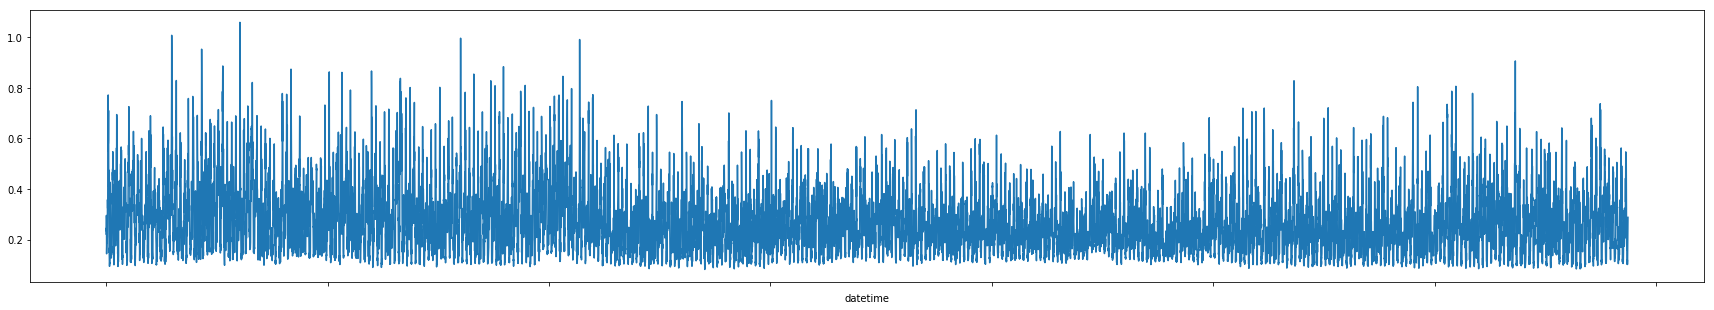

In [9]:
new_train['mean_usage'].plot(figsize=(30,5))

___

### Scale the Data

** Here we scale the data to be in the range (0,1) .. this is important as we are going to use RNNs **

Use sklearn.preprocessing to scale the data using the MinMaxScaler.

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(new_train['mean_usage'].values.reshape(-1, 1))

## Batch Function

In [11]:
def next_batch(training_data, batch_size, steps):
    # A random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Now we set up the RNN Model

** Import TensorFlow **

In [12]:
import tensorflow as tf

### Declare required constants

** We can play with some of these **

In [13]:
# Only one feature (the time series)
num_inputs = 1
# Num of steps in each batch (can be changed)
num_time_steps = 48
# 100 neuron layer (can be changed)
num_neurons = 100
# Just one output (the predicted time series)
num_outputs = 1

# learning rate  (can be changed)
learning_rate = 0.03 
# how many iterations to go through (training steps) ..  (can be changed)
num_train_iterations = 501
# The size of the batch of data
batch_size = 1

** Create Placeholders for X (i.e. the input) and y (the output) **

In [14]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

** Now create the RNN Layer **

Observe that we can use (just examples):
- BasicRNNCells
- BasicLSTMCells
- MultiRNNCell
- GRUCell

In [15]:
# Setup one output using OutputProjectionWrapper and prepare the RNN
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

** Now pass in the cells variable into tf.nn.dynamic_rnn, along with the first placeholder (X)**

In [16]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer **

In [17]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [18]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() so we can save our model **

In [19]:
saver = tf.train.Saver()

### Session

** Here we run a tf.Session that trains on the batches created by the next_batch function. Also add an a loss evaluation for every 100 training iterations. Remember we save the model after training is done. **

In [20]:
# If we are using a GPU
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [21]:
#with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
with tf.Session() as sess:
    sess.run(init)
    # Here we loop through the training data, get random batches and train the RNN
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        # Print out the training MSE every 100 iterations
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for later
    saver.save(sess, "./energy_consumption_rnn_model.ext")

0 	MSE: 63381443000.0
100 	MSE: 0.0033547373
200 	MSE: 0.0029741535
300 	MSE: 0.0034774363
400 	MSE: 0.0050625736
500 	MSE: 0.00456599


______

## Predicting Future Usage (Test Data)
** Remember I am using the average consumption to build the model so all households will have the same predicted usage. I can easily create models and make predictions for individual households but the purpose here is just to demonstrate how I can deal with Time Series Data! **

In [22]:
num_points_to_predict = new_test.shape[0]

** Now we want to attempt to predict future usage for the households. The test data has 336 data points which means we are trying to predict the usage in the next 7 days (336/48). **

We predict using only the training data we had. 

To do this we will feed in a seed training_instance of the last num_points_to_predict points of the training_set of data to predict the next num_points_to_predict into the future.

In [23]:
with tf.Session() as sess:
    
    # Use the saver instance to load the saved rnn time series model
    saver.restore(sess, "./energy_consumption_rnn_model.ext")
    
    # Create a numpy array for the genreative seed from the last num_points_to_predict points of the 
    # training set data.
    train_seed = list(train_scaled[-num_points_to_predict:])
    
    ## Now create a for loop to make the predictions 
    for iteration in range(num_points_to_predict):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./energy_consumption_rnn_model.ext


** Show the result of the predictions. **

In [24]:
len(train_seed)

672

** Here we get the portion of the results that are the generated values and apply inverse_transform on them to turn them back into appropriate consumption units. **

Also we reshape the results to be (num_points_to_predict,1) so we can easily add them to the test dataframe.

In [25]:
results = scaler.inverse_transform(np.array(train_seed[num_points_to_predict:]).reshape(num_points_to_predict,1))

** Create a new column on the test_set called "predicted_usage" and set it equal to the generated results.**

In [26]:
new_test['predicted_usage'] = results

** View the test_set dataframe. **

In [27]:
new_test

,predicted_usage
id,
datetime,
2013-12-10 09:00:00,0.301631
2013-12-10 09:30:00,0.318449
2013-12-10 10:00:00,0.335189
2013-12-10 10:30:00,0.348958
2013-12-10 11:00:00,0.359674
2013-12-10 11:30:00,0.367374
2013-12-10 12:00:00,0.372245
2013-12-10 12:30:00,0.374524


** Let us plot the predicted average consumption **

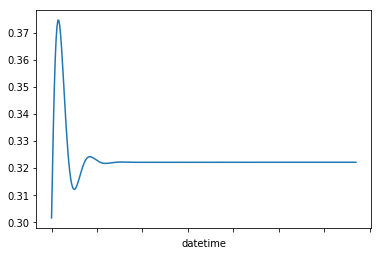

In [28]:
new_test['predicted_usage'].plot()